In [ ]:
#install libraries

!rm -r kdg
!git clone --branch kdf_prog https://github.com/AishwaryaSeth/kdg
!ls
!pip install kdg/.

Cloning into 'kdg'...
remote: Enumerating objects: 4603, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4603 (delta 3), reused 7 (delta 2), pack-reused 4595
Receiving objects: 100% (4603/4603), 55.57 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (1649/1649), done.
kdg  sample_data
Processing ./kdg
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for kdg: filename=kdg-0.0.1-py3-none-any.whl size=15373 sha256=e7931f8b8cac3c7a6295bba4a503252a62541b6c23cba34c0d293013ebb02289
  Stored in directory: /tmp/pip-ephem-wheel-cache-a97vtenn/wheels/e0/72/2b/338836d1623d7accacc7

In [ ]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from matplotlib.ticker import ScalarFormatter

from kdg.kdf import *
from kdg.utils import *


In [ ]:
# Note to Self: Needs to be added to .utils on my branch
def plot_2dsim(X, y, square_plot=False, ax=None):
    """
    Plot 2d simulations.
    Parameters
    ----------
    X : array of shape [n_samples, 2]
        The generated samples. Other dimensions will be ignored.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    square_plot : boolean (default: False)
        If plot should be forced to have square bounds, with (0, 0) at the center
    ax : matplotlib axes object (default: None)
        Axis to plot on. If None, a new axis object will be created.
    Returns
    -------
    ax : matplotlib axes object
        Plot of simulation data.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    samples = np.unique(y)

    if square_plot:
        floor = max(-np.rint(np.amin(X)), np.rint(np.amax(X)))
        print(floor)
        lim = [-floor, floor]
        ax.set_xlim(lim)
        ax.set_ylim(lim)

    colors = sns.color_palette("colorblind")
    for s in samples:
        ax.plot(X[y == s, 0], X[y == s, 1], marker=".", color=colors[s], linestyle="")

    return ax

45-Degree XOR

In [ ]:
fit_kwargs = {"n_estimators": 500, "verbose": 0}
#Get initial KDF
size = 200
overlap = 0.5

In [ ]:
X1, y1 = generate_gaussian_parity(size, cluster_std=overlap)
X2, y2 = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/4)
X1_trans, y1_trans = generate_gaussian_parity(size, cluster_std=overlap)
X2_trans, y2_trans = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/4)
X1_test, y1_test = generate_gaussian_parity(size, cluster_std=overlap)
X2_test, y2_test = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/4)

transfer_kdf = kdf(kwargs = fit_kwargs)
transfer_kdf.fit(X1, y1, task_id = "XOR")
transfer_kdf.fit(X2, y2, task_id = "RXOR")

In the updated KDF!


In [ ]:
xor = np.mean(transfer_kdf.predict(X1_test, "XOR") == y1_test)
print(f"XOR accuracy: {xor}")
rxor = np.mean(transfer_kdf.predict(X2_test, "RXOR") == y2_test)
print(f"RXOR accuracy: {rxor}")

XOR accuracy: 0.75
RXOR accuracy: 0.725


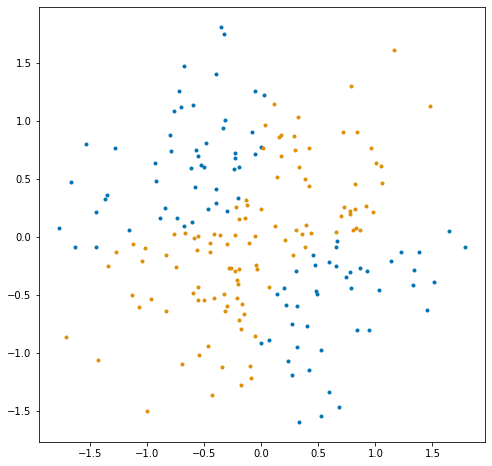

In [ ]:
plot_2dsim(X2_test, transfer_kdf.predict(X2_test, "XOR"))

ProgLearn figures

In [ ]:
def run(mc_rep, n_test, n_nodes, n_xor, n_rxor,
        mean_error, std_error, mean_te, std_te, overlap):
    for i, n1 in enumerate(n_xor):
        print('starting to compute %s xor\n'%n1)
        error = np.array([experiment(n1, 0, task2_angle = np.pi/2, overlap=overlap) for _ in range(mc_rep)])
        mean_error[:, i] = np.mean(error, axis=0)
        std_error[:, i] = np.std(error, ddof=1, axis=0)
        mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
        mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
        mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

        if n1 == n_xor[-1]:
            for j, n2 in enumerate(n_rxor):
                print('starting to compute %s rxor\n'%n2)
                error = np.array([experiment(n1, n2, task2_angle = np.pi/4, overlap=overlap) for _ in range(mc_rep)])

                mean_error[:, i + j + 1] = np.mean(error, axis=0)
                std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
                mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
                mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
                mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
                mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    return mean_error, std_error, mean_te, std_te


def experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_angle=0,
    task2_angle=np.pi / 4,
    overlap = 0.25,
    task1_id="Task1",
    task2_id="Task2",
    dense_layer_nodes = 5,
    random_state=None,
):

    """
    A function to do KDF-FT experiment between two tasks
    where the task data is generated using Gaussian parity.
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
    task2_angle : float, optional (default=numpy.pi/4)
        Angle in radian for task 2.
    task1_id : str, optional (default="Task1")
        Name of Task 1
    task2_angle : float, optional (default="Task2")
        Name of Task 2
    dense_layer_nodes : int, optional (default=5)
        Controls size of neural network
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive KDF error task1,
        naive KDF task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    # source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, cluster_std=overlap, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(
        n_test, cluster_std=overlap, angle_params=task1_angle
    )

    # target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, cluster_std=overlap, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(
        n_test, cluster_std=overlap, angle_params=task2_angle
    )
    
    #Create KDFs
    kdf_task1 = kdf(kwargs = fit_kwargs)
    kdf_task1.fit(X_task1, y_task1, task_id=task1_id)

    if n_task2 == 0:
        single_task1 = kdf_task1.predict(test_task1, task_id=task1_id)
        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1)
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(single_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        kdf_task2 = kdf(kwargs = fit_kwargs)
        kdf_task2.fit(X_task2, y_task2, task_id=task2_id)

        naive_X = np.concatenate((X_task1, X_task2), axis=0)
        naive_y = np.concatenate((y_task1, y_task2), axis=0)
        kdf_naive = kdf(kwargs = fit_kwargs)
        kdf_naive.fit(naive_X, naive_y, task_id="Naive")

        kdf_prog = kdf(kwargs = fit_kwargs)
        kdf_prog.fit(X_task1, y_task1, task_id=task1_id)
        kdf_prog.fit(X_task2, y_task2, task_id=task2_id)
        kdf_prog.forward_transfer(X_task1, y_task1, task_id=task1_id)
        kdf_prog.forward_transfer(X_task2, y_task2, task_id=task2_id)

        single_task1 = kdf_task1.predict(test_task1, task_id=task1_id)
        single_task2 = kdf_task2.predict(test_task2, task_id=task2_id)
        naive_task1 = kdf_naive.predict(test_task1, task_id="Naive")
        naive_task2 = kdf_naive.predict(test_task2, task_id="Naive")
        prog_task1 = kdf_prog.predict(test_task1, task_id=task1_id)
        prog_task2 = kdf_prog.predict(test_task2, task_id=task2_id)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(prog_task1 == test_label_task1)
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(prog_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_task2 == test_label_task2)

    return errors

def plot_error_and_eff(n1s, n2s, mean_error, mean_te, TASK1, TASK2):
    """
    A function that plots the generalization error and
    transfer efficiency for the xor-nxor-rxor experiment
    Parameters
    ----------
    n1s : range(int)
        Array of sample sizes tested for the first learner.
    n2s : range(int)
        Array of sample sizes tested for the second learner.
    mean_error : np.array
        Array of generalization errors.
    mean_te : np.array
        Array of transfer efficiencies.
    task1 : str
        String of the name of the first task.
    task2 : str
        String of the name of the second task.
    """

    ns = np.concatenate((n1s, n2s + n1s[-1]))
    ls = ["-", "--"]

    ################################
    # Plots of Generalization Error
    ################################
    algorithms = [f"Single Task {TASK1}",
                  f"Transfer {TASK1}",
                  f"Single Task {TASK2}",
                  f"Transfer {TASK2}",
                  f"Naive {TASK1}",
                  f"Naive {TASK2}"]

    fontsize = 30
    labelsize = 28

    colors = sns.color_palette("Set1", n_colors=2)

    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    gs = fig.add_gridspec(14, 21)
    ax1 = fig.add_subplot(gs[7:, :6])
    ax1.plot(
        ns,
        mean_error[1],
        label=algorithms[1],
        c=colors[0],
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )
    ax1.plot(
        ns,
        mean_error[0],
        label=algorithms[0],
        c="g",
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    ax1.set_title(f"{TASK1}", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    ax1 = fig.add_subplot(gs[7:, 7:13])

    ax1.plot(
        ns[len(n1s) :],
        mean_error[3, len(n1s) :],
        label=algorithms[3],
        c=colors[0],
        lw=3,
    )
    ax1.plot(
        ns[len(n1s) :], mean_error[2, len(n1s) :], label=algorithms[2], c="g", lw=3
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.5, 0.9])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ax1.set_title(f"{TASK2}", fontsize=30)

    ################################
    # Plots of Transfer Efficiency
    ################################

    algorithms = ["KDF BTE", "KDF FTE", "Naive BTE", "Naive FTE"]

    ax1 = fig.add_subplot(gs[7:, 14:])

    ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[1, len(n1s) :],
        label=algorithms[1],
        c=colors[0],
        ls=ls[1],
        lw=3,
    )
    ax1.plot(ns, mean_te[2], label=algorithms[2], c="g", ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[3, len(n1s) :],
        label=algorithms[3],
        c="g",
        ls=ls[1],
        lw=3,
    )

    ax1.set_ylabel(
        "log Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize
    )
    ax1.legend(loc="lower left", fontsize=20, frameon=False)
    ax1.set_yticks([0.2, 0.6, 1, 1.2])
    ax1.set_ylim(0.2, 1.2)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    log_lbl = np.round(np.log([0.2, 0.6, 1, 1.2]), 2)
    labels = [item.get_text() for item in ax1.get_yticklabels()]

    for ii, _ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])

    ax1.set_yticklabels(labels)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    ax1.hlines(1, 50, 200, colors="gray", linestyles="dashed", linewidth=1.5)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    colors = sns.color_palette("Dark2", n_colors=2)

    X, Y = generate_gaussian_parity(n1s[-1], angle_params=0)
    Z, W = generate_gaussian_parity(n2s[-1], angle_params=np.pi / 2)

    ax = fig.add_subplot(gs[:6, 4:10])
    clr = [colors[i] for i in Y]
    ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Gaussian XOR", fontsize=30)

    ax.axis("off")

    colors = sns.color_palette("Dark2", n_colors=2)

    ax = fig.add_subplot(gs[:6, 11:16])
    clr = [colors[i] for i in W]
    ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Gaussian R-XOR", fontsize=30)
    ax.axis("off")

Experiment

In [ ]:
# define hyperparameters:
mc_rep = 20
n_nodes = 5
n_test = 1000
overlap = 0.25
n_xor = np.arange(10, 101, step=10).astype(int)
n_xnor = np.arange(10, 101, step=10).astype(int)

# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((6, len(n_xor) + len(n_xnor)))
std_error = np.zeros((6, len(n_xor) + len(n_xnor)))
mean_te = np.zeros((4, len(n_xor) + len(n_xnor)))
std_te = np.zeros((4, len(n_xor) + len(n_xnor)))

# run the experiment
mean_error, std_error, mean_te, std_te = run(
    mc_rep, n_test, n_nodes, n_xor, n_xnor,
    mean_error, std_error, mean_te, std_te, overlap
)

starting to compute 10 xor

In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
starting to compute 20 xor

In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
starting to compute 30 xor

In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated K

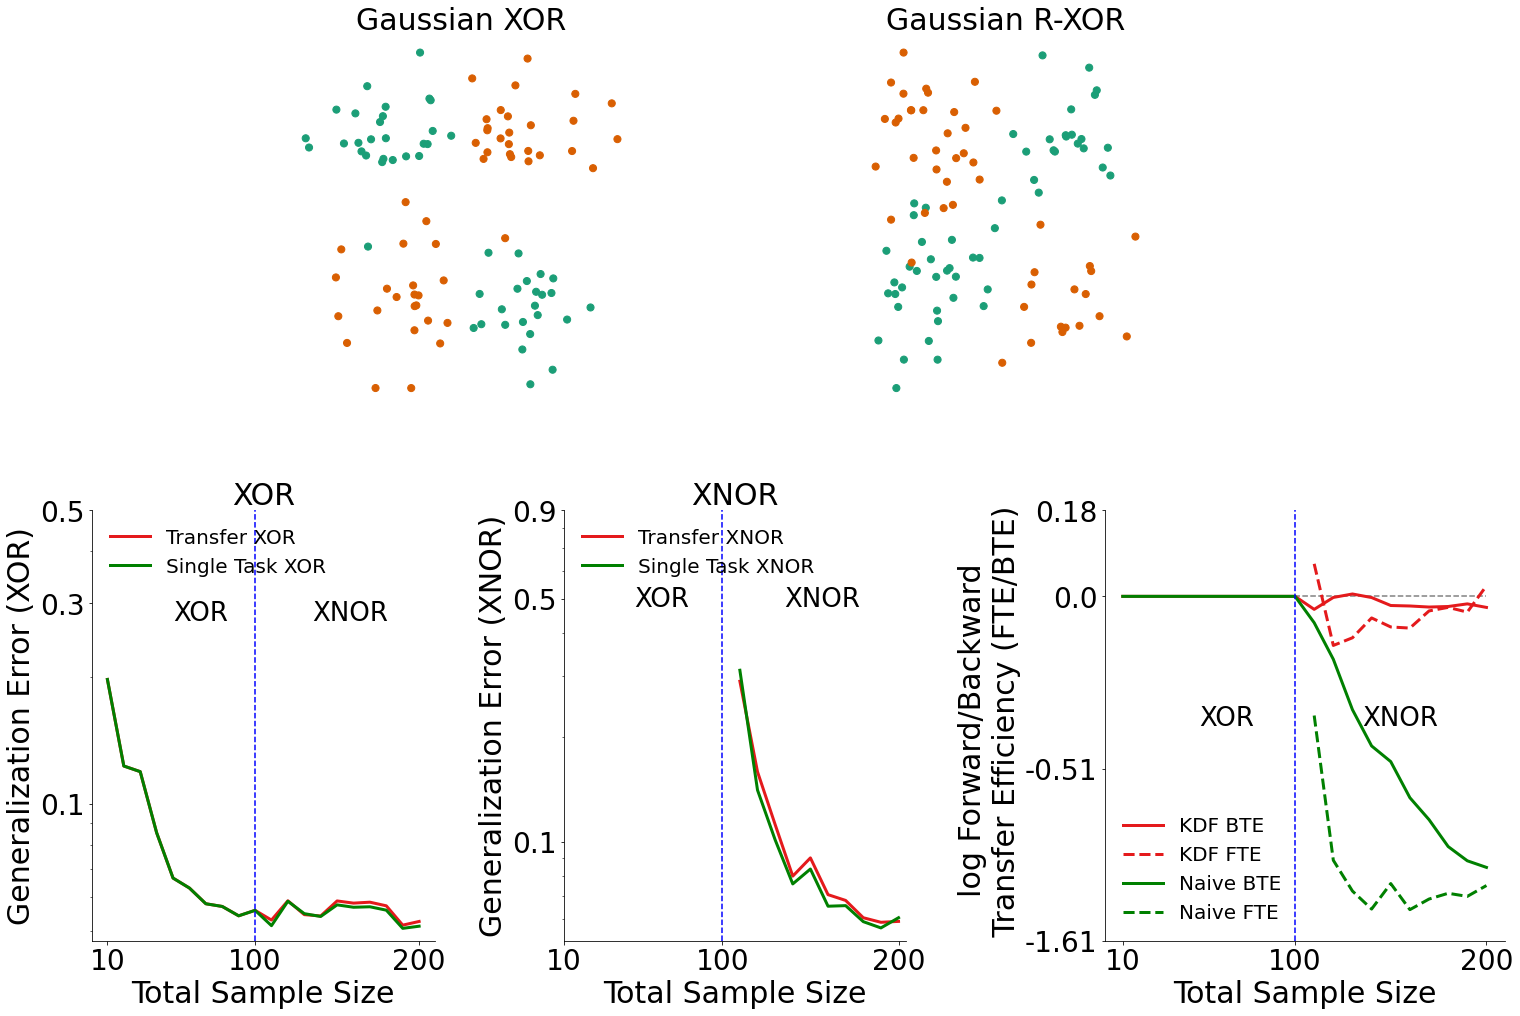

In [ ]:
# plot data
%matplotlib inline
plot_error_and_eff(n_xor, n_xnor, mean_error, mean_te, "XOR", "XNOR")

Bayes

In [ ]:
def plot_accuracy(sample_size, pct_errs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color_list = [(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]
    color_list.extend(sns.color_palette("Set1")[1:])

    for i, err in enumerate(pct_errs):
        ax.plot(sample_size, np.mean(err, axis=1), c=color_list[i], label=labels[i])
        ax.fill_between(
            sample_size,
            np.quantile(err, 0.25, axis=1),
            np.quantile(err, 0.75, axis=1),
            facecolor=color_list[i],
            alpha=0.3,
        )
    
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    #ax.set_xscale("log")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Percent Error")
    ax.legend(frameon=False)

#Bayes Error Test
n_xor = np.arange(20, 301, step=20).astype(int)
n_train = 500
reps = 10
shape = (len(n_xor), reps)

overlaps = np.arange(5, 11, step=1)*0.05
errors = []

for o in overlaps:
    accuracy = []
    print(f"Testing with cluster_std {o}")
    for n in n_xor:
        for r in range(reps):
            X_train, y_train = generate_gaussian_parity(n, cluster_std = o, angle_params = np.pi/4)
            X_test, y_test = generate_gaussian_parity(n_train, cluster_std = o, angle_params = np.pi/4)
            kdf_bayes = kdf(kwargs = fit_kwargs)
            kdf_bayes.fit(X_train, y_train, "RXOR")
            y_hat = kdf_bayes.predict(X_test, "RXOR")
            accuracy.append(np.mean(y_hat == y_test))
    errors.append(1 - np.array(accuracy).reshape(shape))

Testing with cluster_std 0.25
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the upd

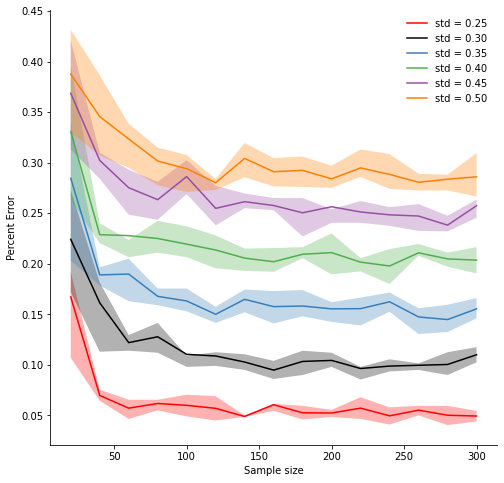

In [ ]:
plot_accuracy(n_xor, errors, [f"std = {o:.2f}" for o in overlaps])

Single Task Gaussian Transfer

In [ ]:
#Source: source of gaussians
#Target: task checked for accuracy
def st_transfer(n_source, n_target, n_test,
               label_source, label_target,
               angle_source, angle_target,
               overlap, dense_layer_nodes = 5,
               random_state = None):
    compile = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
    fit = {"epochs": 100, "batch_size": 32, "verbose": 0}

    # source data
    X_source, y_source = generate_gaussian_parity(n_source,
                                                cluster_std=overlap,
                                                angle_params=angle_source)
    
    # target training data
    X_target, y_target = generate_gaussian_parity(n_target,
                                                  cluster_std=overlap,
                                                  angle_params=angle_target)
    y_label = np.unique(y_target)

    # target testing data
    X_test, y_test = generate_gaussian_parity(n_test,
                                              cluster_std=overlap,
                                              angle_params=angle_target) 
    
    #create kdfs

    kdf_1task = kdf(kwargs = fit_kwargs)
    kdf_1task.fit(X_target, y_target, label_target)

    kdf_rescale = kdf(kwargs = fit_kwargs)
    kdf_rescale.fit(X_source, y_source, label_source)
    kdf_rescale.polytope_sizes[label_target] = np.full([len(kdf_rescale.polytope_sizes[label_source]), 2], fill_value=np.nan)
    kdf_rescale.task_labels[label_target] = y_label
    kdf_rescale.class_priors[label_target] = np.array([np.sum(y_target == L)/len(y_target) for L in y_label])
    kdf_rescale.forward_transfer(X_target, y_target, label_target)

    kdf_2task = kdf(kwargs = fit_kwargs)
    kdf_2task.fit(X_source, y_source, label_source, **fit)
    kdf_2task.fit(X_target, y_target, label_target, **fit)
    kdf_2task.forward_transfer(X_target, y_target, label_target)

    #test_kdns
    errors = np.zeros(3, dtype=float)

    errors[0] = 1 - np.mean(kdf_1task.predict(X_test, label_target) == y_test) #Gaussians fit directly to Task2 only
    errors[1] = 1 - np.mean(kdf_rescale.predict(X_test, label_target) == y_test) #Gaussians fit to Task1, rescaled to task2
    errors[2] = 1 - np.mean(kdf_2task.predict(X_test, label_target) == y_test) #Rescaled gaussians + task2 gaussians both used

    return errors

def run2(mc_rep, n_test, n_task1, n_task2,
         label_source = "XOR", label_target = "RXOR",
         angle_source = 0, angle_target = np.pi/4,
         overlap = 0.25):
    mean_error = np.zeros((3, len(n_task1), len(n_task2)))
    mean_te = np.zeros((2, len(n_task1), len(n_task2)))

    for i, n1 in enumerate(n_task1):
        print(f'\nstarting to compute {n1} {label_source}')
        for j, n2 in enumerate(n_task2):
            print(f'starting to compute {n2} {label_target}')
            error = np.array([st_transfer(n1, n2, n_test, label_source, label_target, angle_source, angle_target, overlap) for _ in range(mc_rep)])

            mean_error[:, i, j] = np.mean(error, axis=0)
            mean_te[0, i, j] = np.mean(error[:, 0]) / np.mean(error[:, 1])
            mean_te[1, i, j] = np.mean(error[:, 0]) / np.mean(error[:, 2])


    return mean_error, mean_te

def get_posteriors(network, label):
    #define grids
    p = np.arange(-3, 3, step=0.01)
    q = np.arange(-3, 3, step=0.01)
    xx, yy = np.meshgrid(p, q)
    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    posteriors = network.predict_proba(grid_samples, label)
    posteriors = posteriors[:,0].reshape(600,600)

    return(posteriors)

In [ ]:
# define hyperparameters:
mc_rep = 10
n_test = 1000
overlap = 0.25
n_t1 = np.arange(50, 501, step=50).astype(int)
n_t2 = np.arange(50, 501, step=50).astype(int)

mean_error, mean_te = run2(mc_rep, n_test, n_t1, n_t2)

np.savez('/content/gdrive/My Drive/kdn_prog_arrs2.npz', task1 = n_t1, task2 = n_t2, mean_error = mean_error, mean_te = mean_te)


starting to compute 50 XOR
starting to compute 50 RXOR
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
starting to compute 100 RXOR
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated KDF!
In the updated 

FileNotFoundError: ignored

SKIPPED TRANSFER EFFICIENCY!

Visualize Posteriors

In [ ]:
X_source, y_source = generate_gaussian_parity(500)
X_target, y_target = generate_gaussian_parity(500, angle_params=np.pi/4)
X_s_test, y_s_test = generate_gaussian_parity(500)
X_t_test, y_t_test = generate_gaussian_parity(500, angle_params=np.pi/4)
label_source = "XOR"
label_target = "RXOR"

kdf_2task = kdf(kwargs = fit_kwargs)
kdf_2task.fit(X_source, y_source, label_source)
kdf_2task.fit(X_target, y_target, label_target)
post_xor = get_posteriors(kdf_2task, label_source)
post_rxr = get_posteriors(kdf_2task, label_target)
xor_acc = np.mean(kdf_2task.predict(X_s_test, label_source) == y_s_test)
rxr_acc = np.mean(kdf_2task.predict(X_t_test, label_target) == y_t_test)

fig1, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0] = plot_2dsim(X_source, y_source, ax=ax[0,0])
ax[1,0] = plot_2dsim(X_target, y_target, ax=ax[1,0])

ax[0, 1].imshow(
    post_xor,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 1].set_title(f"XOR pre-transfer acc={xor_acc}", fontsize=16)
ax[0, 1].set_aspect("equal")

ax[1, 1].imshow(
    post_rxr,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 1].set_title(f"RXOR pre-transfer acc={rxr_acc}", fontsize=16)
ax[1, 1].set_aspect("equal")

kdf_2task.forward_transfer(X_source, y_source, label_source)
kdf_2task.forward_transfer(X_target, y_target, label_target)
post_xor2 = get_posteriors(kdf_2task, label_source)
post_rxr2 = get_posteriors(kdf_2task, label_target)
xor2_acc = np.mean(kdf_2task.predict(X_s_test, label_source) == y_s_test)
rxr2_acc = np.mean(kdf_2task.predict(X_t_test, label_target) == y_t_test)

ax[0, 2].imshow(
    post_xor2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 2].set_title(f"XOR post-transfer acc={xor2_acc}", fontsize=16)
ax[0, 2].set_aspect("equal")

ax[1, 2].imshow(
    post_rxr2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 2].set_title(f"RXOR post-transfer acc={rxr2_acc}", fontsize=16)
ax[1, 2].set_aspect("equal")